In [1]:
print("hello")

hello


In [2]:
import pandas as pd

# List of file paths for the 7 DESeq2 output files
file_paths = [
    "DEA_results_clvb.csv",
    "DEA_results_rs.csv",
    "DEA_results_eb.csv",
    "DEA_results_cf.csv",
    "DEA_results_cf2.csv",
    "DEA_results_lb.csv",
    "DEA_results_lb2.csv",
    "DEA_results_nem.csv",
    "DEA_results_nem2.csv",
    "DEA_results_pvx.csv",
    "DEA_results_tswv.csv",
    "DEA_results_tswv2.csv"]

# Names of the stresses (should match the files' meaning)
stress_names = ["clvb", "rs", "eb", "cf", "cf2", "lb", "lb2", "nem", "nem2", "pvx", "tswv", "tswv2"]

# Thresholds
pvalue_threshold = 0.05
log2fc_threshold = 1.0

# Create an empty dictionary to store filtered gene sets
filtered_genes = {}

# Process each file
for stress, file in zip(stress_names, file_paths):
    # Read the file
    df = pd.read_csv(file)
    
    # Filter by p-value
    df = df[df["pvalue"] <= pvalue_threshold]
    
    # Filter by log2FoldChange
    df = df[(df["log2FoldChange"] >= log2fc_threshold) | (df["log2FoldChange"] <= -log2fc_threshold)]
    
    # Store the filtered gene names
    filtered_genes[stress] = set(df.iloc[:, 0])

# Get a union of all filtered genes across stresses
all_genes = sorted(set.union(*filtered_genes.values()))

# Create the output DataFrame
output_df = pd.DataFrame({"Gene": all_genes})
for stress in stress_names:
    output_df[stress] = output_df["Gene"].apply(lambda gene: gene in filtered_genes[stress])

# Save the output to a CSV file
output_df.to_csv("filtered_genes_matrix.csv", index=False)

print("Filtering completed. Results saved to 'filtered_genes_matrix.csv'.")


Filtering completed. Results saved to 'filtered_genes_matrix.csv'.


In [3]:
import pandas as pd

# Load the selected genes
genes = pd.read_csv("genes.csv")  # Assuming the column name for genes is 'Gene'
selected_genes = set(genes["Gene"])

# List of DESeq2 output files and corresponding stress names
stress_files = {
    "clvb": "DEA_results_clvb.csv",
    "rs": "DEA_results_rs.csv",
    "eb": "DEA_results_eb.csv",
    "cf": "DEA_results_cf.csv",
    "cf2": "DEA_results_cf2.csv",
    "lb": "DEA_results_lb.csv",
    "lb2": "DEA_results_lb2.csv",
    "nem": "DEA_results_nem.csv",
    "nem2": "DEA_results_nem2.csv",
    "pvx": "DEA_results_pvx.csv",
    "tswv": "DEA_results_tswv.csv",
    "tswv2": "DEA_results_tswv2.csv"
}

# Dictionary to hold filtered dataframes for each stress
filtered_stress_data = {}

# Process each stress file and filter it
for stress, file in stress_files.items():
    # Load the DESeq2 file (no header for the first column)
    stress_data = pd.read_csv(file, header=None)
    
    # Rename the columns based on your description
    stress_data.rename(columns={0: "Gene", 2: "log2FoldChange", 5: "pvalue"}, inplace=True)
    
    # Convert columns to numeric, handling errors (invalid entries will be set to NaN)
    stress_data["log2FoldChange"] = pd.to_numeric(stress_data["log2FoldChange"], errors="coerce")
    stress_data["pvalue"] = pd.to_numeric(stress_data["pvalue"], errors="coerce")
    
    # Apply the filtering criteria
    filtered_data = stress_data[
        (stress_data["pvalue"] <= 0.05) & 
        ((stress_data["log2FoldChange"] >= 1.0) | (stress_data["log2FoldChange"] <= -1.0))
    ][["Gene", "log2FoldChange"]]
    
    # Store the filtered data in the dictionary
    filtered_stress_data[stress] = filtered_data

# Merge all filtered dataframes on the "Gene" column
merged_df = None
for stress, data in filtered_stress_data.items():
    if merged_df is None:
        merged_df = data.rename(columns={"log2FoldChange": stress})
    else:
        merged_df = merged_df.merge(
            data.rename(columns={"log2FoldChange": stress}),
            on="Gene",
            how="outer"
        )

# Retain only the genes present in the "genes.csv" file
final_df = merged_df[merged_df["Gene"].isin(selected_genes)]

# Drop rows where all stress columns are "NA"
final_df.dropna(subset=stress_files.keys(), how="all", inplace=True)

# Save the final result to a CSV file
final_df.to_csv("filtered_log2FoldChange_summary1.csv", index=False)

print("Filtered log2FoldChange values extracted and saved to 'filtered_log2FoldChange_summary.csv'")


Filtered log2FoldChange values extracted and saved to 'filtered_log2FoldChange_summary.csv'


/tmp/ipykernel_21287/586091643.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(subset=stress_files.keys(), how="all", inplace=True)


/tmp/ipykernel_21287/3484428964.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_data[stress_columns] = binary_data[stress_columns].applymap(


Correlation matrix calculated and saved to 'stress_correlation_matrix.csv'.


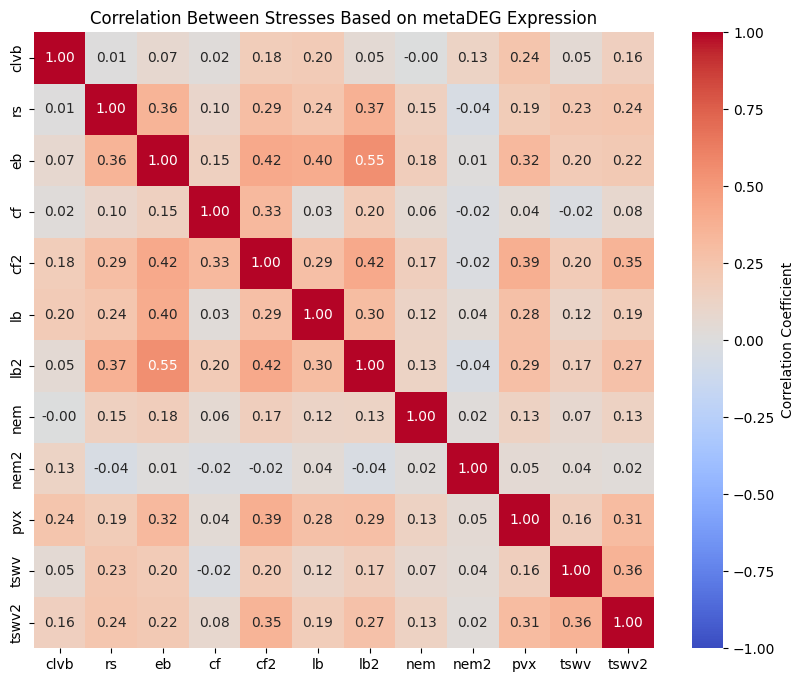

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the filtered log2 fold change summary file
file_path = "filtered_log2FoldChange_summary1.csv"
data = pd.read_csv(file_path)

# Replace "NA" values with NaN for proper numeric calculations
data.replace("NA", np.nan, inplace=True)

# Convert all stress columns (except the 'Gene' column) to numeric
stress_columns = data.columns[1:]  # Exclude the 'Gene' column
data[stress_columns] = data[stress_columns].apply(pd.to_numeric, errors="coerce")

# Create binary representation for upregulated and downregulated genes
# Upregulated: log2FC > 1 → 1, Downregulated: log2FC < -1 → -1, Otherwise → 0
binary_data = data.copy()
binary_data[stress_columns] = binary_data[stress_columns].applymap(
    lambda x: 1 if x > 1 else (-1 if x < -1 else 0)
)

# Compute correlation matrix based on binary values (gene expression patterns)
correlation_matrix = binary_data[stress_columns].corr()

# Save the correlation matrix to a CSV file
correlation_matrix.to_csv("stress_correlation_matrix.csv")

print("Correlation matrix calculated and saved to 'stress_correlation_matrix.csv'.")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1,
            cbar_kws={"label": "Correlation Coefficient"})
plt.title("Correlation Between Stresses Based on metaDEG Expression")
plt.savefig("correlation-stress_metadeg.png")
plt.show()


In [5]:
import pandas as pd

# Load the selected genes
genes = pd.read_csv("genes.csv")  # Assuming the column name for genes is 'Gene'
selected_genes = set(genes["Gene"])


# List of DESeq2 output files and corresponding stress names
stress_files = {
    "clvb": "DEA_results_clvb.csv",
    "rs": "DEA_results_rs.csv",
    "eb": "DEA_results_eb.csv",
    "cf": "DEA_results_cf.csv",
    "cf2": "DEA_results_cf2.csv",
    "lb": "DEA_results_lb.csv",
    "lb2": "DEA_results_lb2.csv",
    "nem": "DEA_results_nem.csv",
    "nem2": "DEA_results_nem2.csv",
    "pvx": "DEA_results_pvx.csv",
    "tswv": "DEA_results_tswv.csv",
    "tswv2": "DEA_results_tswv2.csv"
}

# Dictionary to hold filtered dataframes for each stress
filtered_stress_data = {}

# Process each stress file and filter it
for stress, file in stress_files.items():
    # Load the DESeq2 file (no header for the first column)
    stress_data = pd.read_csv(file, header=None)
    
    # Rename the columns based on your description
    stress_data.rename(columns={0: "Gene", 2: "log2FoldChange", 5: "pvalue"}, inplace=True)
    
    # Convert columns to numeric, handling errors (invalid entries will be set to NaN)
    stress_data["log2FoldChange"] = pd.to_numeric(stress_data["log2FoldChange"], errors="coerce")
    stress_data["pvalue"] = pd.to_numeric(stress_data["pvalue"], errors="coerce")
    
    # Apply the filtering criteria
    filtered_data = stress_data[
        (stress_data["pvalue"] <= 0.05) & 
        ((stress_data["log2FoldChange"] >= 1.0) | (stress_data["log2FoldChange"] <= -1.0))
    ][["Gene"]]
    
    # Store the filtered data in the dictionary with a binary "presence" column
    filtered_data[stress] = 1
    filtered_stress_data[stress] = filtered_data

# Merge all filtered dataframes on the "Gene" column
merged_df = None
for stress, data in filtered_stress_data.items():
    if merged_df is None:
        merged_df = data
    else:
        merged_df = merged_df.merge(data, on="Gene", how="outer")

# Replace NaN values with 0 (indicating absence of a gene in that stress)
merged_df.fillna(0, inplace=True)

# Ensure the columns are integers (0 or 1)
for stress in stress_files.keys():
    merged_df[stress] = merged_df[stress].astype(int)

# Retain only the genes present in the "genes.csv" file
final_df = merged_df[merged_df["Gene"].isin(selected_genes)]

# Save the final result to a CSV file
final_df.to_csv("binary_presence_summary.csv", index=False)

print("Binary presence values extracted and saved to 'binary_presence_summary.csv'.")


Binary presence values extracted and saved to 'binary_presence_summary.csv'.


In [9]:
pip install matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 1.2 MB/s eta 0:00:000:00:01m eta 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.2 MB/s eta 0:00:001.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.2 MB/s eta 0:00:00 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sigprofilerplotting 1.4.0 requires scikit-learn>=1.1.3, which is not installed.
sigprofilermatrixgenerator 1.3.0 requires scipy>=1.12.0, which is not installed.
sigprofilermatrixgenerator 1.3.0 requires statsmodels>=0.9.0, which is not installed.
sigprofilerextractor 1.2.0 requires scikit-learn>=0.24.2,

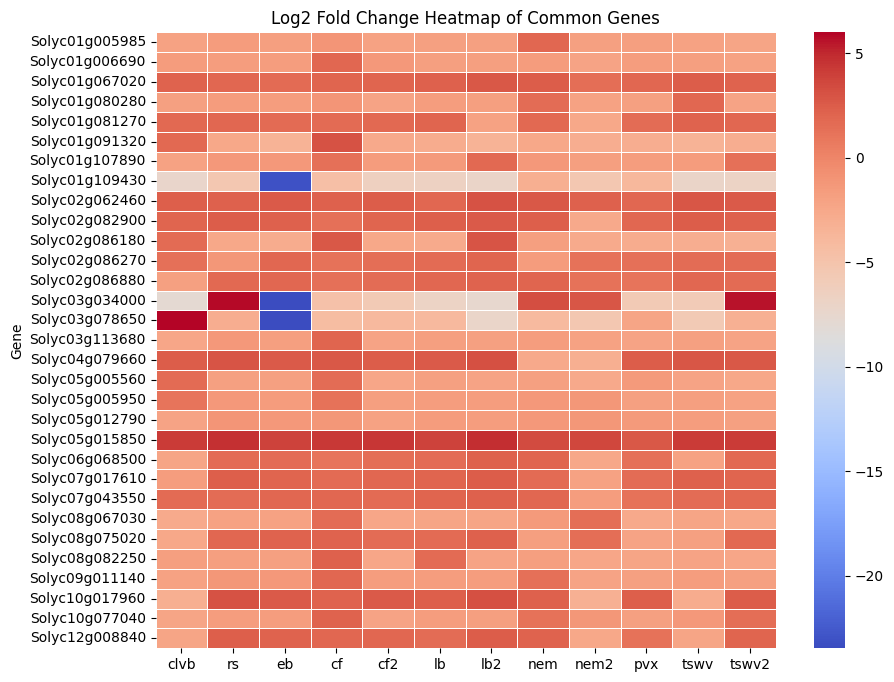

Processing complete! Common genes, heatmap, and sorted gene lists saved.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv("filtered_log2FoldChange_summary1.csv")

# Drop 'Gene' column from filtering process
stresses = df.columns[1:]  # All stress columns
common_genes_df = df.dropna(subset=stresses)  # Keep rows without NaN in all stress columns

# Save common genes to CSV
common_genes_df.to_csv("common_genes.csv", index=False)

# Heatmap visualization of log2FC values
plt.figure(figsize=(10, 8))
sns.heatmap(common_genes_df.set_index("Gene"), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Log2 Fold Change Heatmap of Common Genes")
plt.savefig("common_genes_heatmap.png", dpi=300)
plt.show()

# Identify consistently upregulated and downregulated genes
upregulated_genes = df[(df[stresses] > 0).all(axis=1)]
downregulated_genes = df[(df[stresses] < 0).all(axis=1)]

# Save upregulated and downregulated genes to CSV
upregulated_genes.to_csv("upregulated_genes.csv", index=False)
downregulated_genes.to_csv("downregulated_genes.csv", index=False)

print("Processing complete! Common genes, heatmap, and sorted gene lists saved.")


Category-wise summary saved to category_wise_summary.csv.


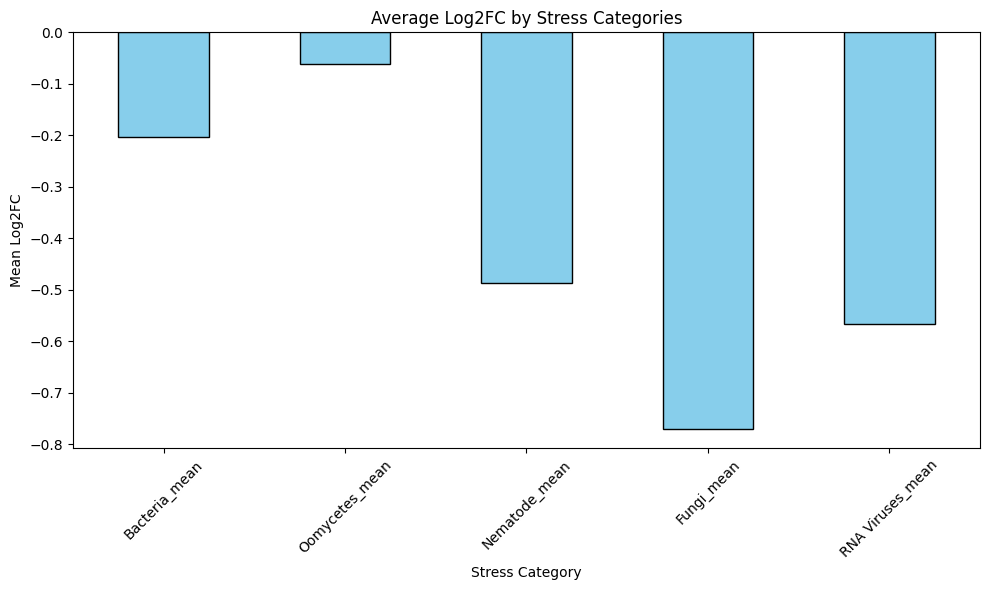

Category correlation matrix saved to category_correlation_matrix.csv.


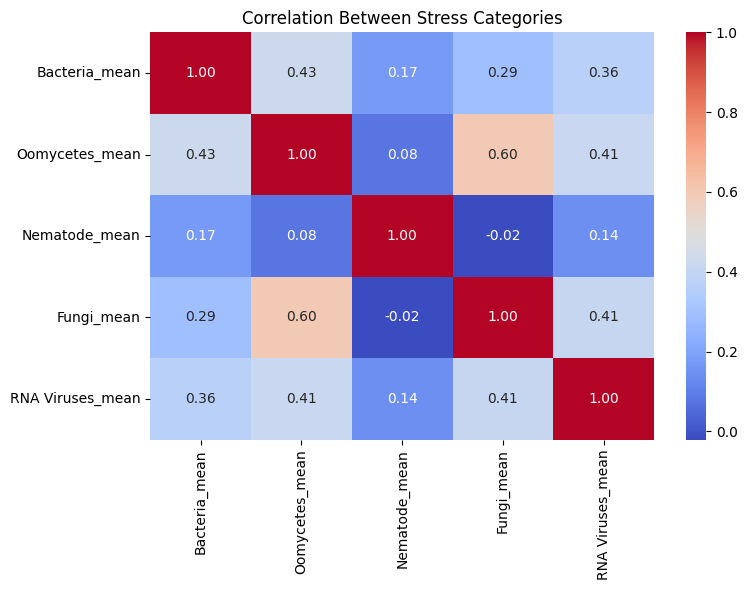

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the input file
file_path = "filtered_log2FoldChange_summary1.csv"
data = pd.read_csv(file_path)

# Replace "NA" or empty strings with NaN for proper numeric calculations
data.replace("NA", np.nan, inplace=True)

# Convert all stress columns (except the 'Gene' column) to numeric
stress_columns = data.columns[1:]  # Exclude the 'Gene' column
data[stress_columns] = data[stress_columns].apply(pd.to_numeric, errors="coerce")

# Define stress categories
categories = {
    "Bacteria": ["clvb","rs"],
    "Oomycetes": ["lb", "lb2"],
    "Nematode": ["nem", "nem2"],
    "Fungi": ["eb", "cf", "cf2"],
    "RNA Viruses": ["pvx", "tswv", "tswv2"]
}

# Prepare results dictionary
category_means = {}
category_stddevs = {}
category_counts = {}

# Analyze each category
for category, stresses in categories.items():
    category_data = data[stresses]
    
    # Mean log2FC for the category
    category_means[category] = category_data.mean(axis=1, skipna=True)
    
    # Standard deviation of log2FC for the category
    category_stddevs[category] = category_data.std(axis=1, skipna=True)
    
    # Count of non-NaN values for the category
    category_counts[category] = category_data.notna().sum(axis=1)

# Combine results into a single DataFrame
summary_df = pd.DataFrame({
    "Gene": data["Gene"],
    **{f"{cat}_mean": category_means[cat] for cat in categories},
    **{f"{cat}_stddev": category_stddevs[cat] for cat in categories},
    **{f"{cat}_count": category_counts[cat] for cat in categories}
})

# Save the results to a CSV file
summary_csv_path = "category_wise_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)
print(f"Category-wise summary saved to {summary_csv_path}.")

# Visualize the mean log2FC values for each category
category_mean_columns = [f"{cat}_mean" for cat in categories]
mean_values = summary_df[category_mean_columns].mean()

plt.figure(figsize=(10, 6))
mean_values.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Log2FC by Stress Categories")
plt.ylabel("Mean Log2FC")
plt.xlabel("Stress Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("category_mean_log2FC.png")
plt.show()

# Calculate pairwise correlations between categories
category_data = summary_df[category_mean_columns]
correlation_matrix = category_data.corr()

# Save the correlation matrix to a CSV
correlation_csv_path = "category_correlation_matrix.csv"
correlation_matrix.to_csv(correlation_csv_path)
print(f"Category correlation matrix saved to {correlation_csv_path}.")

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Between Stress Categories")
plt.tight_layout()
plt.savefig("category_correlation_heatmap.png")
plt.show()


c:\Users\2019ag6004\AppData\Local\Programs\Python\Python313\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\2019ag6004\AppData\Local\Programs\Python\Python313\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

<Figure size 1200x600 with 0 Axes>

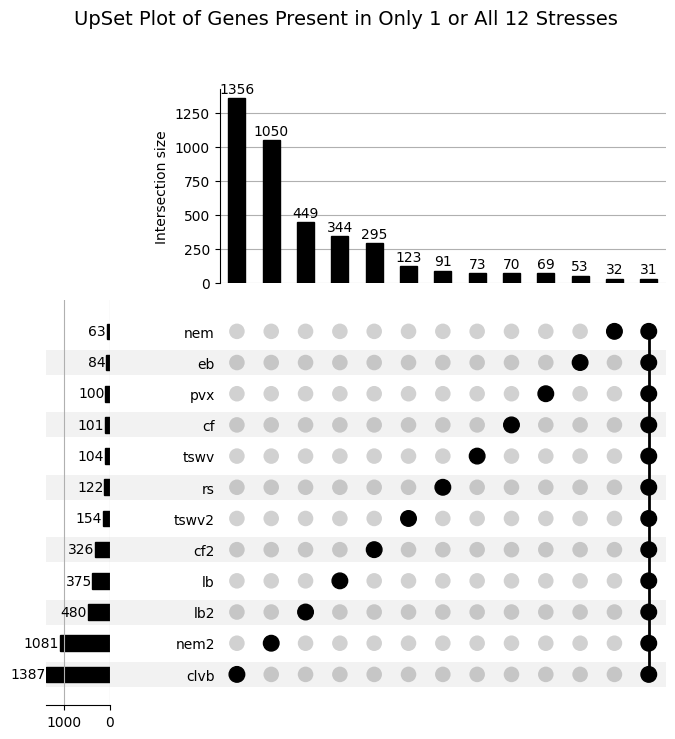

In [13]:
import pandas as pd
from upsetplot import from_indicators, UpSet
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("filtered_log2FoldChange_summary1.csv")

# Convert non-empty entries to True (gene present), NaN/empty stays False
binary_df = df.drop(columns=["Gene"]).notna()
binary_df["Gene"] = df["Gene"]

# Count how many stresses each gene appears in
binary_df["count"] = binary_df.drop(columns=["Gene"]).sum(axis=1)

# Filter genes present in all 12 or only one stress
filtered_df = binary_df[(binary_df["count"] == 1) | (binary_df["count"] == 12)]

# Remove the count column for UpSet plot input
filtered_df = filtered_df.drop(columns=["count"])

# Set 'Gene' as index and convert to boolean
filtered_df.set_index("Gene", inplace=True)
filtered_df = filtered_df.astype(bool)

# Prepare data for upsetplot
upset_data = from_indicators(filtered_df.columns.tolist(), filtered_df)

# Plot
plt.figure(figsize=(12, 6))
UpSet(upset_data, subset_size='count', show_counts=True).plot()
plt.suptitle("UpSet Plot of Genes Present in Only 1 or All 12 Stresses", fontsize=14)
plt.tight_layout()
# plt.savefig("Filtered_Meta_DEGs_UpSetPlot.png")
plt.show()


c:\Users\2019ag6004\AppData\Local\Programs\Python\Python313\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\2019ag6004\AppData\Local\Programs\Python\Python313\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

<Figure size 2400x800 with 0 Axes>

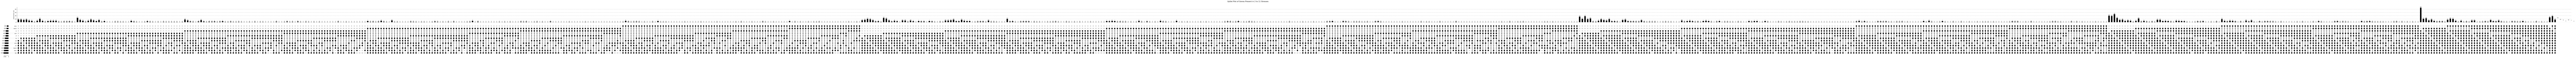

In [22]:
import pandas as pd
from upsetplot import from_indicators, UpSet
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("filtered_log2FoldChange_summary1.csv")

# Convert non-empty entries to True, empty stays False
binary_df = df.drop(columns=["Gene"]).notna()
binary_df["Gene"] = df["Gene"]

# Count how many stresses each gene appears in
binary_df["count"] = binary_df.drop(columns=["Gene"]).sum(axis=1)

# Filter genes present in 2 to 11 stresses
filtered_df = binary_df[(binary_df["count"] >= 6) & (binary_df["count"] <= 11)]

# Drop the count column and convert to boolean
filtered_df = filtered_df.drop(columns=["count"])
filtered_df.set_index("Gene", inplace=True)
filtered_df = filtered_df.astype(bool)

# Prepare for UpSet plot
upset_data = from_indicators(filtered_df.columns.tolist(), filtered_df)

# Plot
plt.figure(figsize=(24, 8))
UpSet(upset_data, subset_size='count', show_counts=True).plot()
plt.suptitle("UpSet Plot of Genes Present in 2 to 11 Stresses", fontsize=16)
plt.tight_layout()
plt.savefig("2Meta_DEGs_UpSetPlot.png")
plt.show()
